In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

from collections import deque
import glob
import pickle

%matplotlib inline

## Camera Calibration

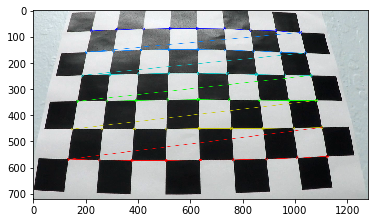

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        plt.imshow(img)
        

...


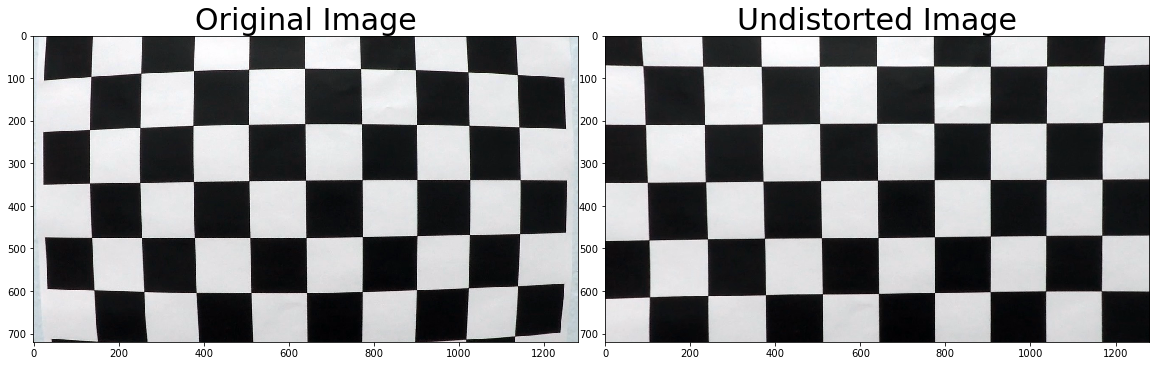

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1][1:], None,None)
pickle.dump({'mtx': mtx, 'dist': dist}, open("cam_calibration.p", "wb"))
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

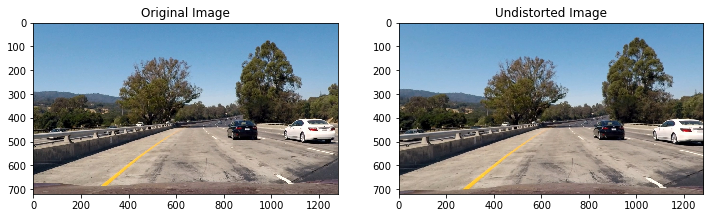

In [5]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(1, 2, 2)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")

## Create thresholded binary images

In [6]:
def gaussian_blur(img, sigma):
    kernel_size = 11
    return cv2.GaussianBlur(img, (kernerl_size, kernel_size), sigma)

def abs_sobel_thresh(img, thresh_min=25, thresh_max=255, sobel_kernel=7, orient='x'):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    bin_output = np.zeros_like(scaled_sobel)
    bin_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return bin_output

def mag_thresh(img, sobel_kernel=7, thresh_min=25, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(magnitude)/255 
    magnitude = (magnitude/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    bin_output = np.zeros_like(magnitude)
    bin_output[(magnitude >= thresh_min) & (magnitude <= thresh_max)] = 1

    return bin_output

def directional_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradient = np.arctan2(np.abs(sobely), np.abs(sobelx))
  
    dir_binary = np.zeros_like(gradient)
    dir_binary[(gradient > thresh_min) & (gradient <= thresh_max)] = 1
                       
    return dir_binary

def color_thresh(img, thresh_min=0, thresh_max=255):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    s = hls[:, :, 2]
    bin_output = np.zeros_like(s)
    bin_output[(s > thresh_min) & (s <= thresh_max)] = 1
    return bin_output

def transform_perspective(img, src, dst):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [7]:
src = np.float32([[490, 482],[810, 482],
                 [1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                  [1250, 720],[40, 720]])


#def pipeline(img):
#    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
#    warped = transform_perspective

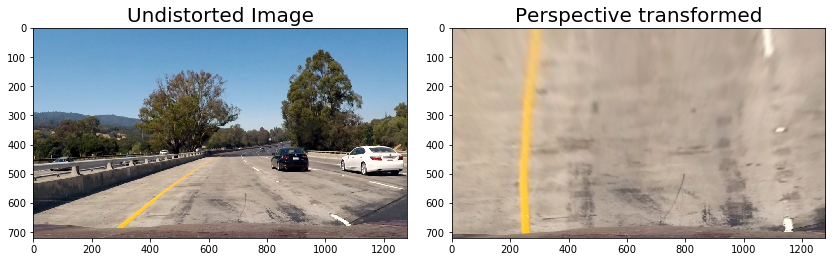

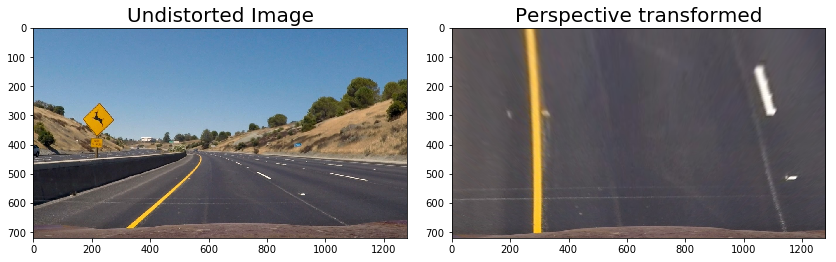

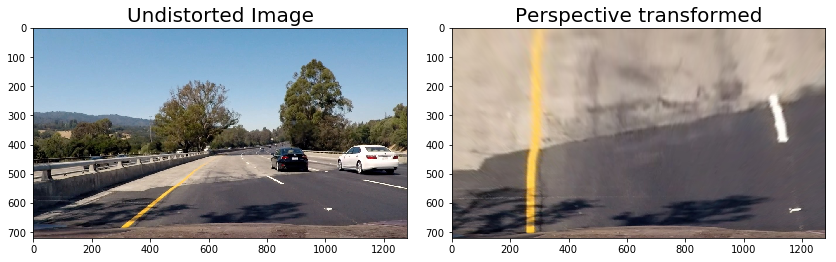

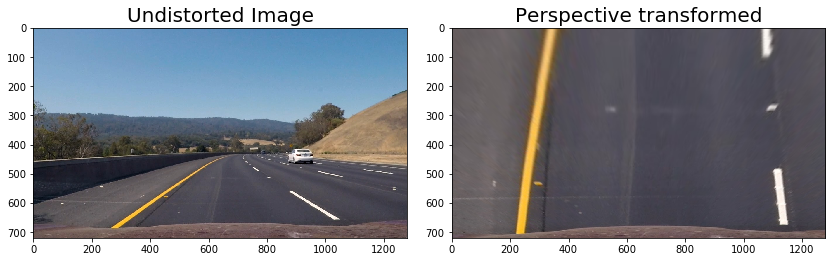

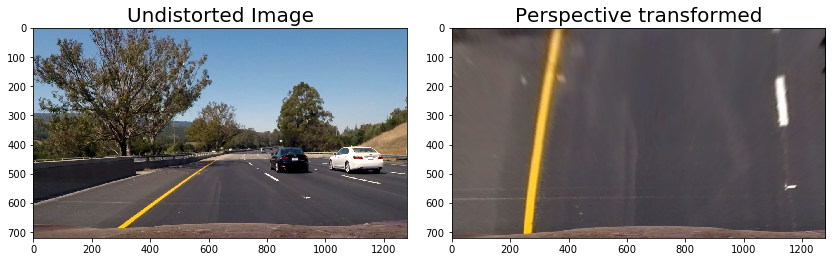

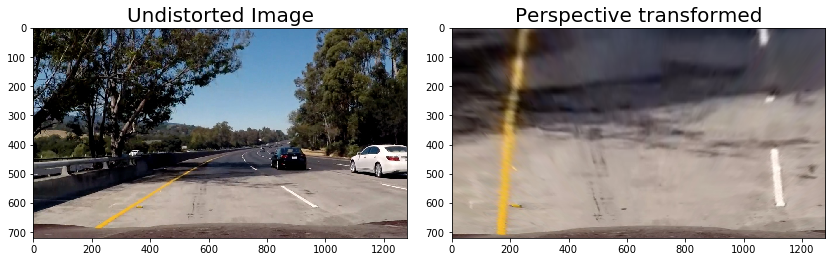

In [8]:
for fname in glob.glob("test_images/test*.jpg"):
    #fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    #img = cv2.resize(img, (720, 405))
    
    warped = transform_perspective(img, src, dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Perspective transformed', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


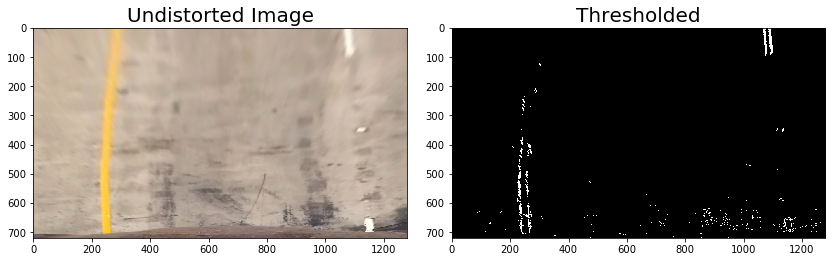

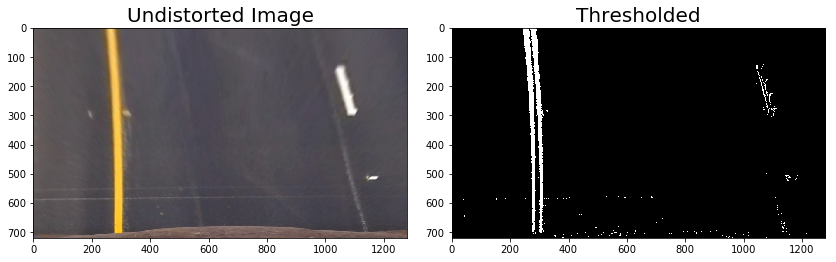

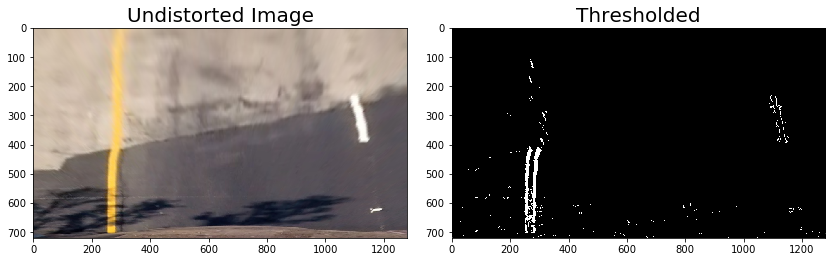

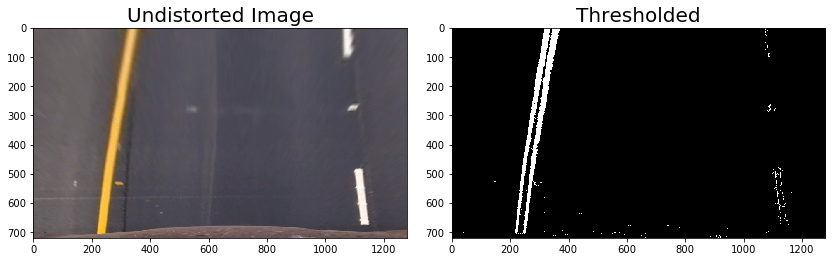

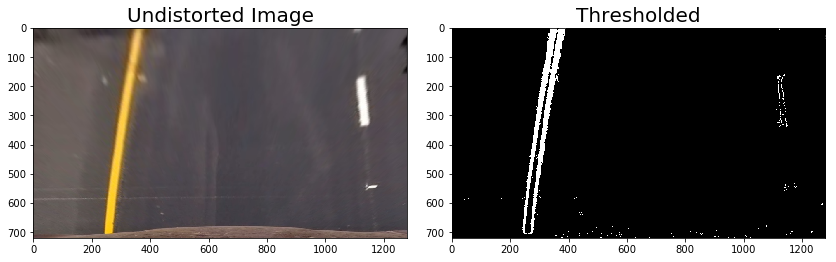

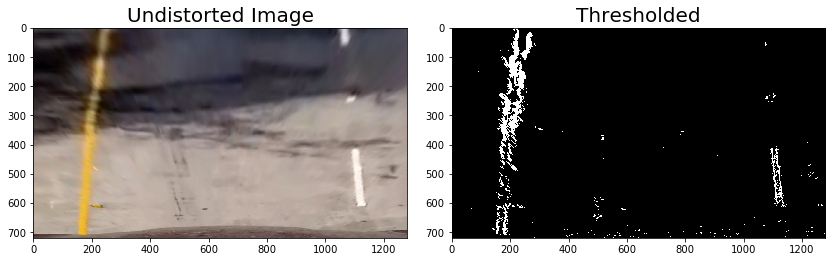

In [11]:
#def apply_thresholds(image):
for fname in glob.glob("test_images/test*.jpg"):
    image = mpimg.imread(fname)
    warped = transform_perspective(image, src, dst)
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    grad_x = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh_min=10, thresh_max=230)
    grad_y = abs_sobel_thresh(warped, orient='y', sobel_kernel=3, thresh_min=10, thresh_max=230)
    mag_binary = mag_thresh(warped, sobel_kernel=3, thresh_min=30, thresh_max=150)
    dir_binary = directional_thresh(warped, sobel_kernel=3, thresh_min=0.7, thresh_max=1.3)
    hls_binary = color_thresh(warped, thresh_min=85, thresh_max=255)
    combined = np.zeros_like(dir_binary)
    
    combined[((grad_x == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(warped)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(combined,cmap='gray' )
    ax2.set_title('Thresholded', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280)
180 1111


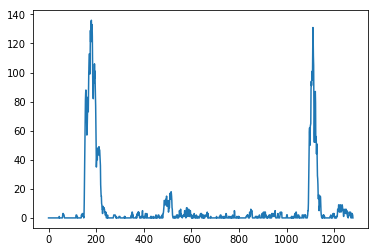

In [16]:
histogram = np.sum(combined[int(combined.shape[0]/2):,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

In [ ]:
warped = combined

def sliding_window_polyfit(img):
    histogram = np.sum(combined[int(img.shape[0]/2):,:], axis=0)

    # Peak in the first half indicates the likely position of the left lane
    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])

    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(histogram[half_width:]) + half_width
    
    #out_img = np.uint8(np.dstack((img, img, img))*255)

    non_zeros = img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]

    num_windows = 12
    num_rows = warped.shape[0]
    window_height = np.int(num_rows/num_windows)
    window_half_width = 80

    min_pixels = 50

    left_coordinates = []
    right_coordinates = []
    
    rectangle_params = []
    #right_rectangles_params = []

    for window in range(num_windows):
        y_max = num_rows - window * window_height
        y_min = num_rows - (window + 1) * window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width
        
        rectangle_params.extend([(left_x_min, y_min), (left_x_max, y_max), [0,0,255],2])
        #cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        
        rectangle_params.extend([(right_x_min, y_min), (right_x_max, y_max), [0,0,255],2])
        #cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)

    out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
    out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]

    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]

    polyfit_right = np.polyfit(right_y, right_x, 2)

    y_points = np.linspace(0, num_rows-1, num_rows)

    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    '''
    plt.imshow(out_img)
    plt.plot(left_x_predictions, y_points, color='yellow')
    plt.plot(right_x_predictions, y_points, color='blue')
    plt.xlim(0, warped.shape[1])
    plt.ylim(warped.shape[0],0)
    '''
    
    return left_x_predictions, right_x_predictions, polyfit_left, polyfit_right, y_points, rectangle_params, histogram
sliding_window_polyfit(warped)

In [ ]:
def search_around_previous_fit(binary_warped, left_fit, right_fit):
    #From udacity
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, ploty, left_fitx, right_fitx


In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)



In [ ]:
def get_curvature(y, fitx):

    y_eval = np.max(y)
    # Define conversions in x and y from pixels space to meters
    # assume the lane is about 30 meters long and 3.7 meters wide
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    fit_cr = np.polyfit(y * ym_per_pix, fitx * xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return curverad

def get_position(pts, image_shape = (720, 1280)):
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    return (position - center) * xm_per_pix